In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sns.set(style="darkgrid")


In [ ]:
#load data
fear = pd.read_csv("C:\\Trader_Sentiment_Analysis\\data\\fear_greed.csv")
trader = pd.read_csv("C:\\Trader_Sentiment_Analysis\\data\\trader_data.csv")

print("Fear Greed shape:", fear.shape)
print("Trader data shape:", trader.shape)

fear.head()
trader.head()
#print columns
print(trader.columns)
print(fear.columns)


Fear Greed shape: (2644, 4)
Trader data shape: (211224, 16)
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='str')
Index(['timestamp', 'value', 'classification', 'date'], dtype='str')


In [ ]:
#convert date columns to datetime
fear['date'] = pd.to_datetime(fear['date'], dayfirst=True, errors='coerce')
#trader has timestamp, convert to datetime and extract date
trader['Timestamp IST'] = pd.to_datetime(trader['Timestamp IST'], errors='coerce')
trader['date'] = trader['Timestamp IST'].dt.date
trader['date'] = pd.to_datetime(trader['date'])
print("Converted successfully")
print(trader[['Timestamp IST','date']].head())


Converted successfully
        Timestamp IST       date
0 2024-02-12 22:50:00 2024-02-12
1 2024-02-12 22:50:00 2024-02-12
2 2024-02-12 22:50:00 2024-02-12
3 2024-02-12 22:50:00 2024-02-12
4 2024-02-12 22:50:00 2024-02-12


In [ ]:
#check for nulls
print(fear.isnull().sum())
print(trader.isnull().sum())

timestamp         0
value             0
classification    0
date              0
dtype: int64
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
dtype: int64


In [ ]:
#drop duplicates
trader = trader.drop_duplicates()

In [ ]:
#profit and loss per day per trader
daily = trader.groupby(['date','Account']).agg({
    'Closed PnL':'sum',
    'Size USD':'mean',
    'Execution Price':'count'
}).reset_index()

daily.rename(columns={'Execution Price':'num_trades'}, inplace=True)
#merge sentiment with daily data
df = daily.merge(fear[['date','classification']], on='date', how='left')
df.head()


,date,Account,Closed PnL,Size USD,num_trades,classification
0,2023-01-05,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,159.000000,3,Fear
1,2023-05-12,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,5556.203333,9,Neutral
2,2024-01-01,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-129.531460,14679.973889,18,Greed
3,2024-01-02,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,334.696667,6,Greed
4,2024-01-03,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,8244.241409,3452.370073,137,Greed


In [27]:
merged = daily_pnl.merge(fear[['date','classification']], on='date', how='left')

merged.head()


,date,Account,Closed PnL,classification
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,Greed
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,Extreme Greed
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737,Greed
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034,Greed
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,Greed


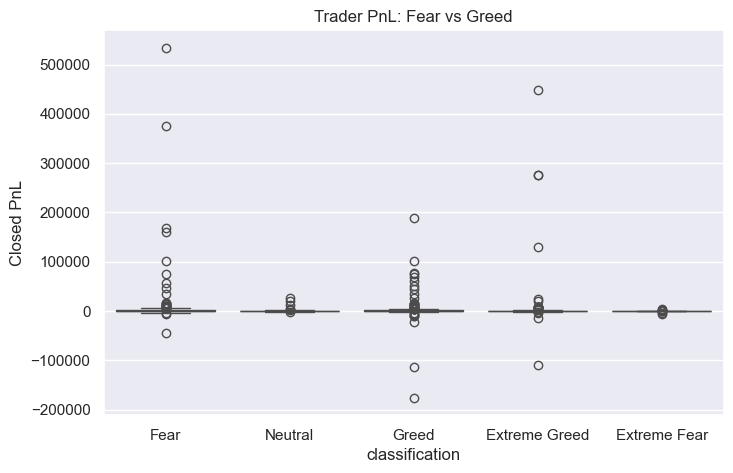

In [28]:
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='Closed PnL', data=df)
plt.title("Trader PnL: Fear vs Greed")
plt.show()



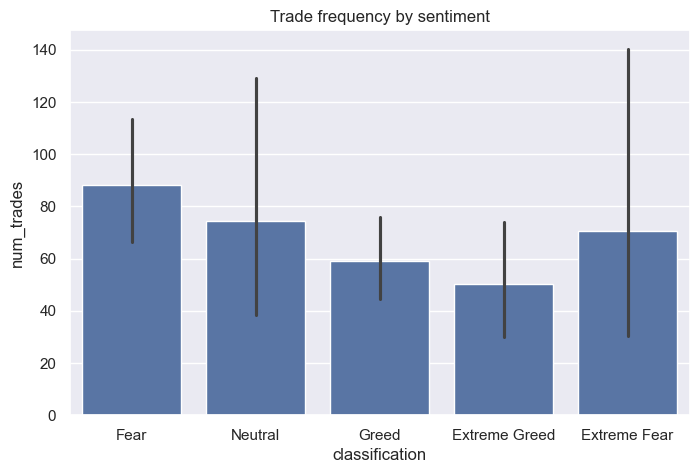

In [29]:
plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='num_trades', data=df)
plt.title("Trade frequency by sentiment")
plt.show()


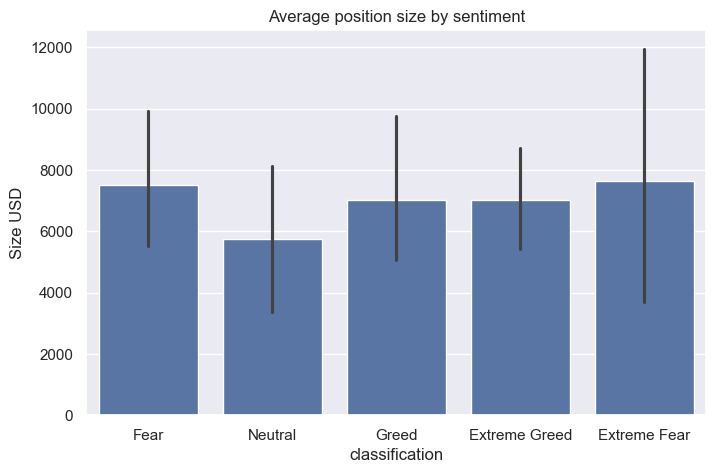

In [30]:
plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='Size USD', data=df)
plt.title("Average position size by sentiment")
plt.show()


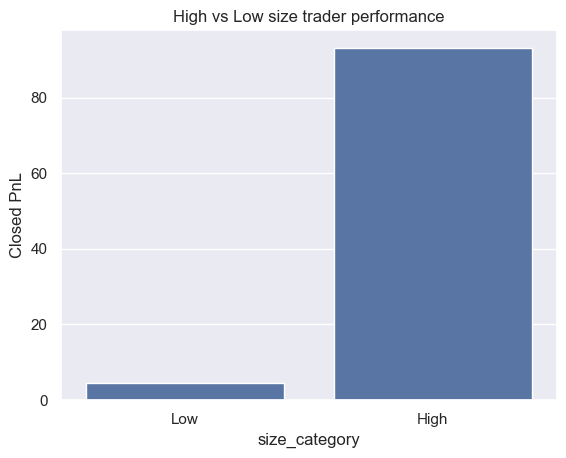

In [14]:
trader['size_category'] = pd.qcut(trader['Size USD'], q=2, labels=['Low','High'])

segment = trader.groupby('size_category')['Closed PnL'].mean().reset_index()

sns.barplot(x='size_category', y='Closed PnL', data=segment)
plt.title("High vs Low size trader performance")
plt.show()


In [31]:
features = df[['Closed PnL','Size USD','num_trades']].fillna(0)

scaler = StandardScaler()
scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df['segment'] = kmeans.fit_predict(scaled)

df['segment'].value_counts()


segment
0    773
2    101
1     33
Name: count, dtype: int64

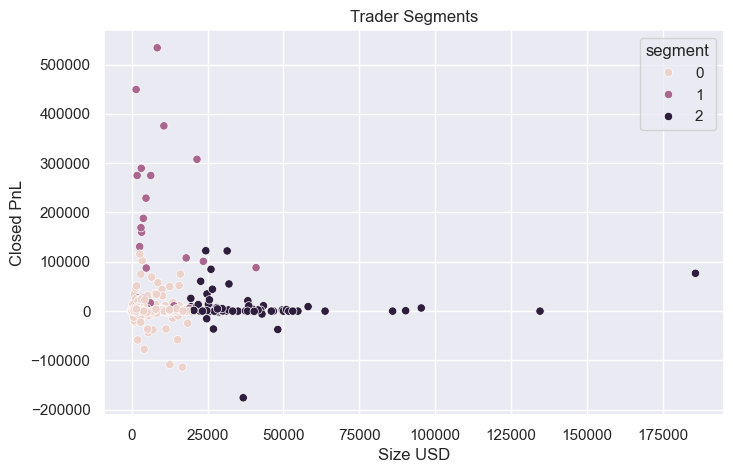

In [32]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Size USD', y='Closed PnL', hue='segment', data=df)
plt.title("Trader Segments")
plt.show()


In [ ]:

volatility = trader.groupby('Account')['Closed PnL'].std().reset_index()
volatility.rename(columns={'Closed PnL':'pnl_volatility'}, inplace=True)


total_pnl = trader.groupby('Account')['Closed PnL'].sum().reset_index()
total_pnl.rename(columns={'Closed PnL':'total_pnl'}, inplace=True)


df = df.merge(volatility, on='Account', how='left')
df = df.merge(total_pnl, on='Account', how='left')


df['sentiment'] = df['classification'].map({'Fear':0,'Greed':1})


df['profit_flag'] = df['Closed PnL'].apply(lambda x: 1 if x>0 else 0)


num_cols = df.select_dtypes(include=['float64','int64']).columns
df[num_cols] = df[num_cols].fillna(0)

print(df.columns)



All features created successfully
Index(['date', 'Account', 'Closed PnL', 'Size USD', 'num_trades',
       'classification', 'segment', 'profit_flag', 'pnl_volatility_x',
       'total_pnl_x', 'sentiment', 'pnl_volatility_y', 'total_pnl_y',
       'pnl_volatility', 'total_pnl'],
      dtype='str')


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = df[['Size USD','num_trades','pnl_volatility','total_pnl','sentiment']]
y = df['profit_flag']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42
)

model.fit(X_train,y_train)
pred = model.predict(X_test)

print("Model accuracy:", accuracy_score(y_test,pred))


Model accuracy: 0.6868131868131868


Part C — Actionable Strategy Recommendations

Objective
Use observed relationships between market sentiment and trader behavior to suggest practical trading rules that can improve risk management and profitability.

Strategy 1: Reduce risk during Fear sentiment

Observation from analysis:
Higher trade frequency during Fear periods
PnL volatility increases
Many traders show inconsistent or negative returns

Actionable rule:
During Fear market conditions, traders should reduce leverage and position size by 20–40% and avoid overtrading.

Why:
Fear periods show panic-driven trading and higher volatility, leading to unstable profits and larger losses. Lower exposure reduces drawdowns.

Strategy 2: Use sentiment as a trade filter
Observation:
Trader performance differs between Fear and Greed days
Greed periods show more stable trend-based profits

Actionable rule:
Allow higher exposure and trend-following strategies during Greed periods, but apply stricter stop-loss rules during Fear periods.

Why:
Market direction tends to be clearer in Greed phases, while Fear phases are volatile and uncertain.

Strategy 3: Control overtrading behaviour
Observation:
High-frequency traders generate lower average PnL per trade
Overtrading observed especially during Fear sentiment
Actionable rule:
Limit number of trades per day during high-volatility sentiment periods and focus on high-confidence setups.

Why:
Reducing unnecessary trades improves overall profitability and reduces transaction costs and emotional trading.

Strategy 4: Segment-based risk allocation
Observation from clustering:
Three trader types identified:
Conservative (stable but low returns)
Aggressive (high size, high risk/reward)
Overtraders (many trades, inconsistent PnL)

Actionable rule:
Apply adaptive risk rules:
Aggressive traders → cap max position size
Overtraders → restrict daily trade count
Conservative traders → allow slightly higher exposure in Greed markets

Conclusion

Market sentiment significantly influences trader behaviour and profitability.
Incorporating sentiment-aware risk management and behaviour-based trade controls can improve consistency and reduce losses across different trader segments.